In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import Sequential, Input, Model, regularizers
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense, LSTM, Reshape, BatchNormalization, UpSampling1D
from tensorflow.train import AdamOptimizer
from keras.callbacks import EarlyStopping
import tensorflow as tf

tf.enable_eager_execution()


REGULAR = "reg"
CHIMERIC = "chi"
REPEAT = "rep"
LOW_QUALITY = "loq"

INPUT_LENGTH = 5000
INPUT_THRESHOLD = 1000

NUM_CLASSES = 3

Using TensorFlow backend.


In [13]:
def create_deep_encoder(input_shape):
    dense1 = Dense(2500, activation="relu")(input_shape)
    dense2 = Dense(2000, activation="relu")(dense1)
    dense3 = Dense(1500, activation="relu")(dense2)
    dense4 = Dense(1000, activation="relu")(dense3)
    dense5 = Dense(500, activation="relu")(dense4)
    dense6 = Dense(250, activation="relu")(dense5)

    return dense6


def create_deep_decoder(encoder):
    dense7 = Dense(500, activation="relu")(encoder)
    dense8 = Dense(1000, activation="relu")(dense7)
    dense9 = Dense(1500, activation="relu")(dense8)
    dense10 = Dense(2000, activation="relu")(dense9)
    dense11 = Dense(2500, activation="relu")(dense10)
    output = Dense(5000, activation="sigmoid")(dense11)

    return output


def create_deep_autoencoder():
    input_shape = Input(shape=(INPUT_LENGTH, ))
    model = Model(input_shape, create_deep_decoder(create_deep_encoder(input_shape)))

    model.compile(optimizer=AdamOptimizer(learning_rate=0.00005), loss='binary_crossentropy')

    print(model.summary())

    return model

In [17]:

def create_datasets(tsv_input):
    data = pd.read_csv(tsv_input, delimiter="\t")

    # Filter out all low quality reads
    data = data.loc[data.CAT != LOW_QUALITY]

    # Convert sequence string to float array
    data.PTS = data.PTS.apply(string_to_array)

    # Convert labels from strings to ints
    ys = data.CAT.apply(category_to_int).to_numpy()
    xs = np.stack(data.PTS.array)

    encoded_ys = to_categorical(ys, num_classes=NUM_CLASSES)

    print("XS shape: {}".format(xs.shape))
    print("One-hot encoded YS shape: {}".format(encoded_ys.shape))

    train_x, test_x, train_y, test_y = train_test_split(xs, encoded_ys, test_size=0.15)

    return train_x, train_y, test_x, test_y


def string_to_array(data):
    data_string = str(data)
    split = data_string.split(',')

    return np.array([float(i) for i in split])


def category_to_int(data):
    category = str(data)
    if category == REGULAR:
        return 0
    elif category == REPEAT:
        return 1
    else:
        return 2
    

def evaluate_autoencoder(model, train_x, train_y, test_x, test_y, epochs_num):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    cp = ModelCheckpoint(filepath="autoencoder_classifier.h5", save_best_only=True, verbose=0)
    
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=epochs_num,
        validation_data=(test_x, test_y),
        callbacks=[es, cp]
    )

    decoded_x = model.predict(test_x)
    print("Decoded samples shape: {}".format(decoded_x.shape))

    plot_decoded(test_x, decoded_x)

    plot_loss(history, epochs_num)


def plot_decoded(original_x, decoded_x):
    n = 20  # how many overlaps we will display
    idxs = range(5000)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        plt.subplot(2, n, i + 1)
        plt.plot(idxs, original_x[i].tolist())
        plt.gray()
        # display reconstruction
        plt.subplot(2, n, i + 1 + n)
        plt.plot(idxs, decoded_x[i].tolist())
        plt.gray()
    plt.show()


def plot_loss(model, epochs_num):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(1, epochs_num + 1)
    plt.figure()
    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(matrix):
    df_cm = pd.DataFrame(matrix, ["regular", "repeat", "chimeric"], ["regular", "repeat", "chimeric"])
    plt.figure(figsize=(10, 7))
    sb.heatmap(df_cm, annot=True)
    plt.show()
    

def test_autoencoder(dataset):
    model = create_deep_autoencoder()

    train_x, _, test_x, _ = create_datasets(dataset)

    print(np.max(train_x))
    train_x = train_x / np.max(train_x)
    test_x = test_x / np.max(test_x)
    print(np.max(train_x))

    evaluate_autoencoder(model, train_x, train_x, test_x, test_x, epochs_num=150)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 2500)              12502500  
_________________________________________________________________
dense_28 (Dense)             (None, 2000)              5002000   
_________________________________________________________________
dense_29 (Dense)             (None, 1500)              3001500   
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_31 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_32 (Dense)             (None, 250)               125250    
__________

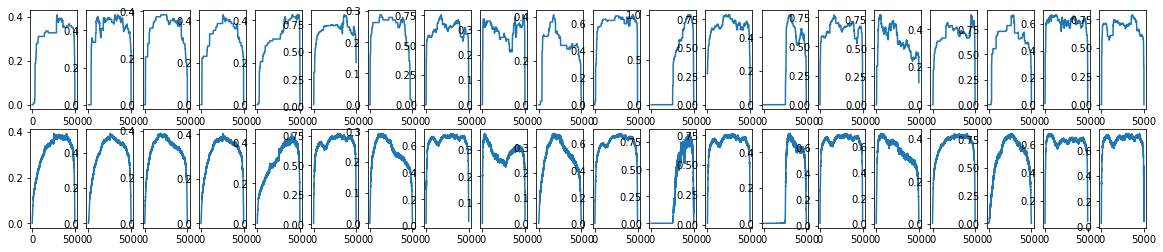

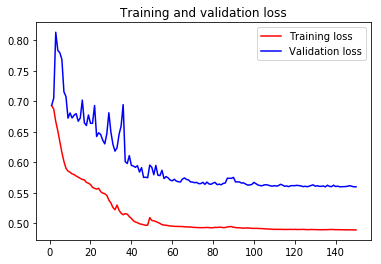

In [18]:
test_autoencoder("/floyd/input/labeled_400/categorized_400.tsv")